<a href="https://colab.research.google.com/github/kei-mo/deep-learning-from-scratch-5/blob/main/notebooks/09_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 9: Diffusion Model

## SETUP

In [1]:
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-5/main/step09/flower.png

--2024-12-30 06:28:04--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-5/main/step09/flower.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8568 (8.4K) [image/png]
Saving to: ‘flower.png’

flower.png          100%[===================>]   8.37K  --.-KB/s    in 0s      

2024-12-30 06:28:04 (88.4 MB/s) - ‘flower.png’ saved [8568/8568]



## simple_unet.py

In [3]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.convs(x)


class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # upsample:

    def forward(self, x):
        x1 = self.down1(x)
        x = self.maxpool(x1)
        x2 = self.down2(x)
        x = self.maxpool(x2)

        x = self.bot1(x)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)
        x = self.out(x)
        return x


model = UNet()
x = torch.randn(10, 1, 28, 28)  # dummy input
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


## gauusian_noise.py

- Forward diffusion

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)


# explanation:
for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps
print(x.shape)
print(x)


torch.Size([3, 64, 64])
tensor([[[-1.7498, -1.5298,  0.0509,  ...,  0.5144, -0.5321, -0.6221],
         [ 1.3978, -1.0015, -0.2256,  ...,  0.2485,  0.4298, -0.5948],
         [-0.5257,  0.3901,  0.7886,  ...,  0.2626,  0.8959, -2.5792],
         ...,
         [ 0.9649,  0.5719,  1.2856,  ...,  0.8768,  0.8902,  1.1329],
         [ 0.1633,  1.6069, -1.9412,  ..., -0.7904,  0.0248,  2.2435],
         [ 0.6864,  0.7745, -0.8763,  ...,  0.0672,  1.6032, -0.2448]],

        [[ 0.6266, -0.7037, -0.8644,  ..., -0.8198,  0.7599,  0.3147],
         [ 0.6188, -1.2977, -0.2297,  ...,  0.6648,  1.4864, -0.8988],
         [ 2.0059, -0.6498,  0.8281,  ...,  1.3255,  0.3206,  0.4234],
         ...,
         [-0.4264,  0.3662, -0.5801,  ..., -0.1925,  1.4325, -0.0284],
         [-1.4467, -0.4682,  0.8821,  ...,  1.7468, -0.1701, -0.6714],
         [-0.3164,  0.8101, -1.1931,  ..., -0.3161, -0.8242,  0.6737]],

        [[ 0.5673, -2.2154,  1.3982,  ..., -0.5444, -0.2648, -0.0029],
         [-0.0120,  0

#### 1stepずつのforwad diffusion
- t=0から1stepずつ順番にノイズを追加するコード
- 続くq(x_t|x_0)で一度にt時点でのノイズが乗った画像を計算する方法を実装

(64, 64, 3)
torch.Size([3, 64, 64])


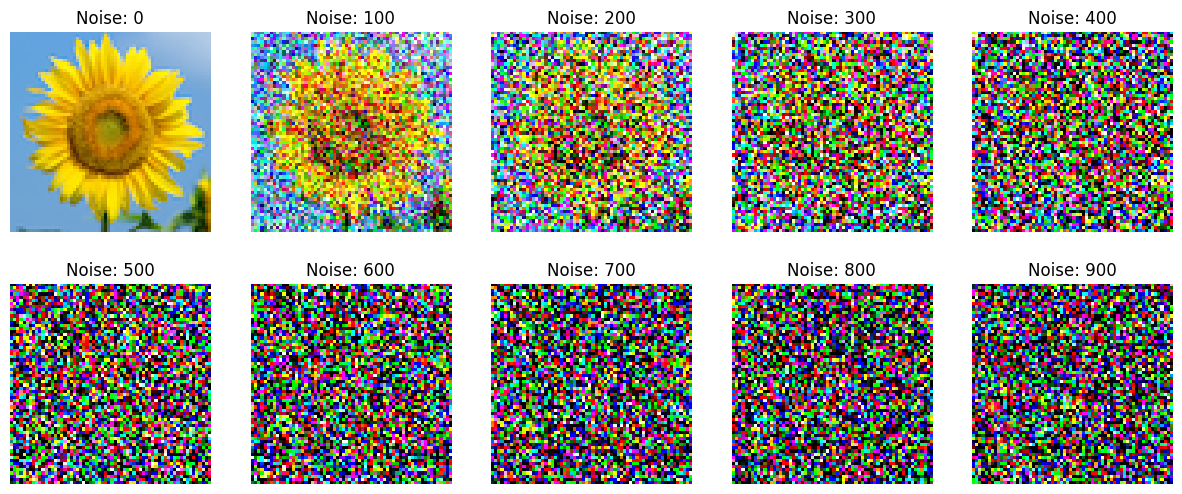

In [5]:


# load image
file_path = 'flower.png'
image = plt.imread(file_path)
print(image.shape)  # (64, 64, 3)

# preprocess
# image shapeの変更とテンソル化
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)  # (3, 64, 64)

original_x = x.clone()  # keep original image

def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

# explanation: t=0から1stepずつ順番にノイズを追加するコード
# 続くq(x_t|x_0)で一度にt時点でのノイズが乗った画像を計算する方法を実装
for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)

    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# show imgs
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()


#### q(x_t|x_0) ✅
- 一度にt時点でのノイズが乗った画像を計算する方法を実装
- 個人Notion: https://www.notion.so/16b879ef7ef480a0b67ac566ec9dd601?pvs=4

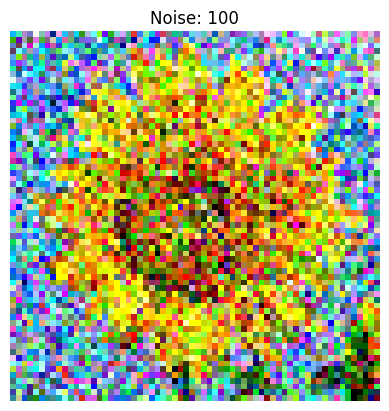

In [6]:
# ============================================
# q(x_t|x_0)
# ============================================
def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T
    t_idx = t - 1  # betas[0] is for t=1

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t

x = original_x

t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

## diffusion_model.py

In [7]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()




#### Positional Encoding
- 正数tをベクトルv（D=output_dim次元）に変換する
    - vの各次元は異なる周波数で変換されている
- output_dimはおそらくハイパラ. 下ではtime_embed_dimとして与えられている
- vは各conv blockに入力として与えられる.



位置エンコーディングは、以下の **正弦関数 (sin)** と **余弦関数 (cos)** に基づいて計算されます。

##### 偶数次元 (2i) の計算式
$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{D}}}\right)
$$

##### 奇数次元 (2i+1) の計算式
$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{D}}}\right)
$$

##### 各変数の意味
- \( pos \): シーケンス内の位置インデックス  
- \( i \): 次元インデックス（偶数と奇数で処理を分ける）  
- \( D \): エンコードするベクトルの次元数  

##### 特性

1. **ユニークな表現**: 各位置に固有のエンコードが割り当てられる。  
2. **相対的な位置情報の保持**: 隣接する位置は類似したエンコードを持つため、距離関係が保たれる。  
3. **スケール不変性**: 高周波から低周波までをカバーするため、短いシーケンスから長いシーケンスまで対応可能。


![positiona_encoding](https://github.com/kei-mo/deep-learning-from-scratch-5/blob/main/step09/pos_encoding.png?raw=true)




##### 使われ方
- 最終的にはvは各ConvBlockに入力される (p.218 図9-8)
- 各ConvBlock内ではまずvはMLPにより画像・チャネルごとに1つの値が割り当てられる。各チャネル全体に同じ値が適用されるスカラー値のように扱われるが、実際はテンソルとしてブロードキャストされる定数値
- その後xに定数値が足されてconv2dに入力される
- TODO: 各画像・チャネルごとに定数値として足して機能する感覚がつかめない. 具体的に各t, ConvBlockに対してどういう値が足されている?
- TODO: 元論文でどうしてpositional encodingを使う発想となったか調べたい.
- TODO: 疑問: x+vの際にスケールは合わせる必要なし?

In [8]:

def _pos_encoding(time_idx, output_dim, device='cpu'):
    """
    time_idx: int
    output_dim: int
    return: (output_dim,)
    """
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])

    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    """
    timesteps: (batch_size,)
    output_dim: int
    return: (batch_size, output_dim)
    """
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device) # deviceの設定あっている?
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v



In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        # Conv Block
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

        # v (N,D)→(N,C)の変換
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v) # (N, C)
        v = v.view(N, C, 1, 1)
        # ✏️view(): テンソルの 形状を変更 するために使用されます。 データのコピーは作成されず、元のテンソルと同じデータを参照します。

        # xに直接加算
        # TODO: 疑問: スケールは合わせる必要なし?
        y = self.convs(x + v)

        return y

class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        # TODO: time emded dimとは?→ positional encodingの際の埋め込み先の次元数

        self.down1 = ConvBlock(in_ch=in_ch, out_ch=64, time_embed_dim=time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # TODO: upsample:

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x


In [10]:


class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images


In [11]:

preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.57MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



========Epoch: 0========


100%|██████████| 469/469 [00:54<00:00,  8.59it/s]


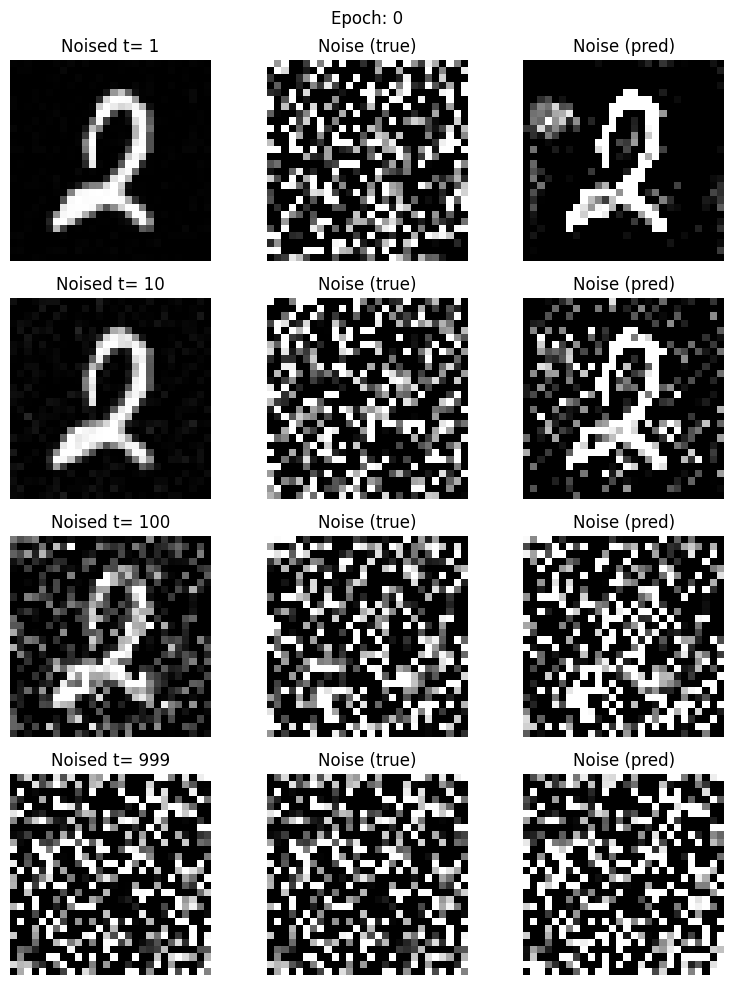

100%|██████████| 1000/1000 [00:10<00:00, 95.08it/s]


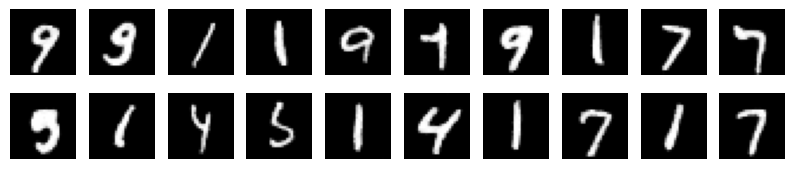

Epoch 0 | Loss: 0.017472829651842114
========Epoch: 1========


100%|██████████| 469/469 [00:54<00:00,  8.58it/s]


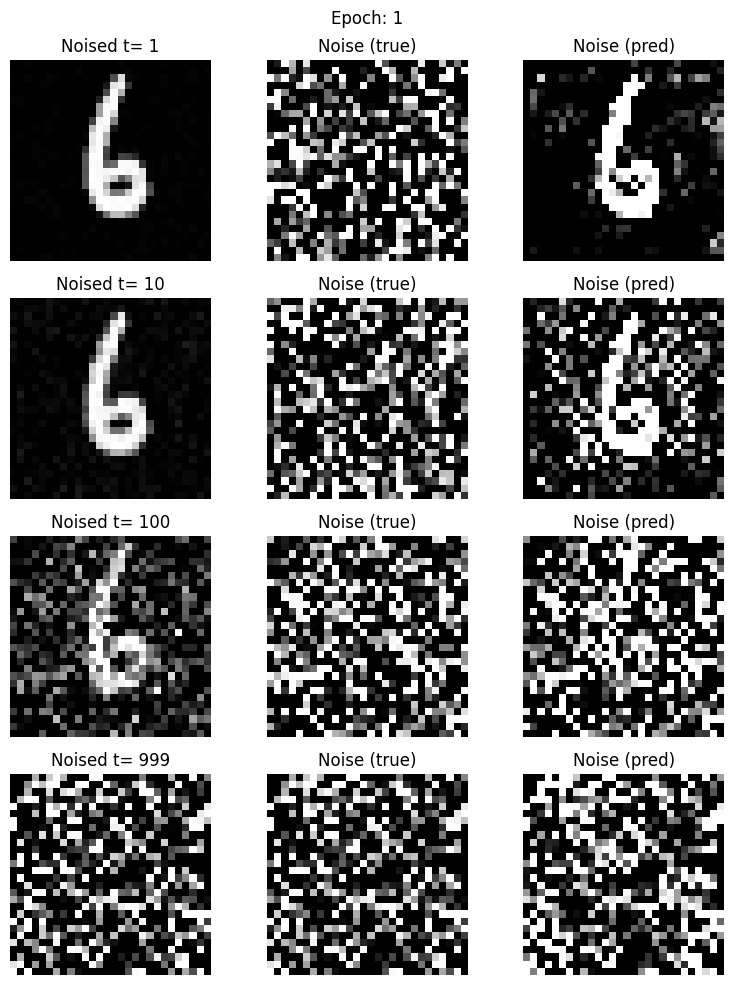

100%|██████████| 1000/1000 [00:10<00:00, 98.43it/s]


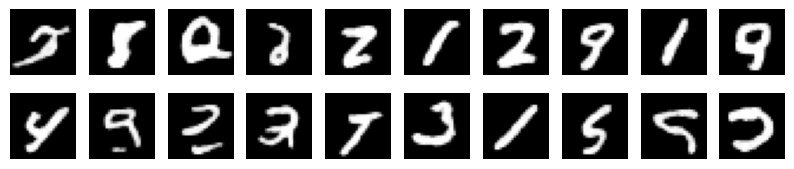

Epoch 1 | Loss: 0.017449310214232915
========Epoch: 2========


100%|██████████| 469/469 [00:54<00:00,  8.58it/s]


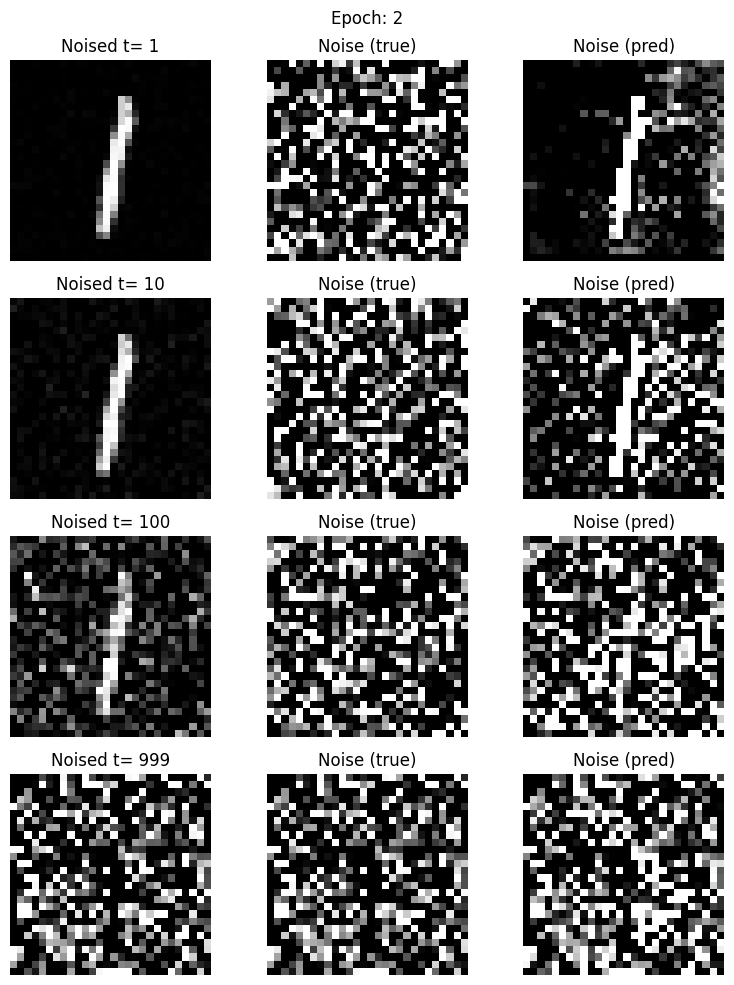

100%|██████████| 1000/1000 [00:10<00:00, 99.22it/s]


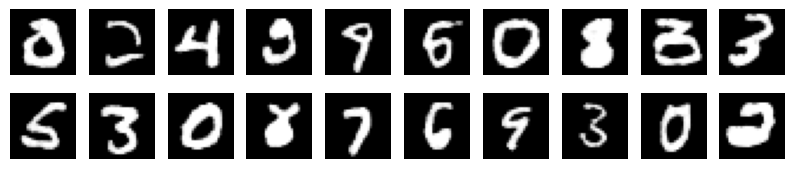

Epoch 2 | Loss: 0.017155574604884774
========Epoch: 3========


100%|██████████| 469/469 [00:55<00:00,  8.42it/s]


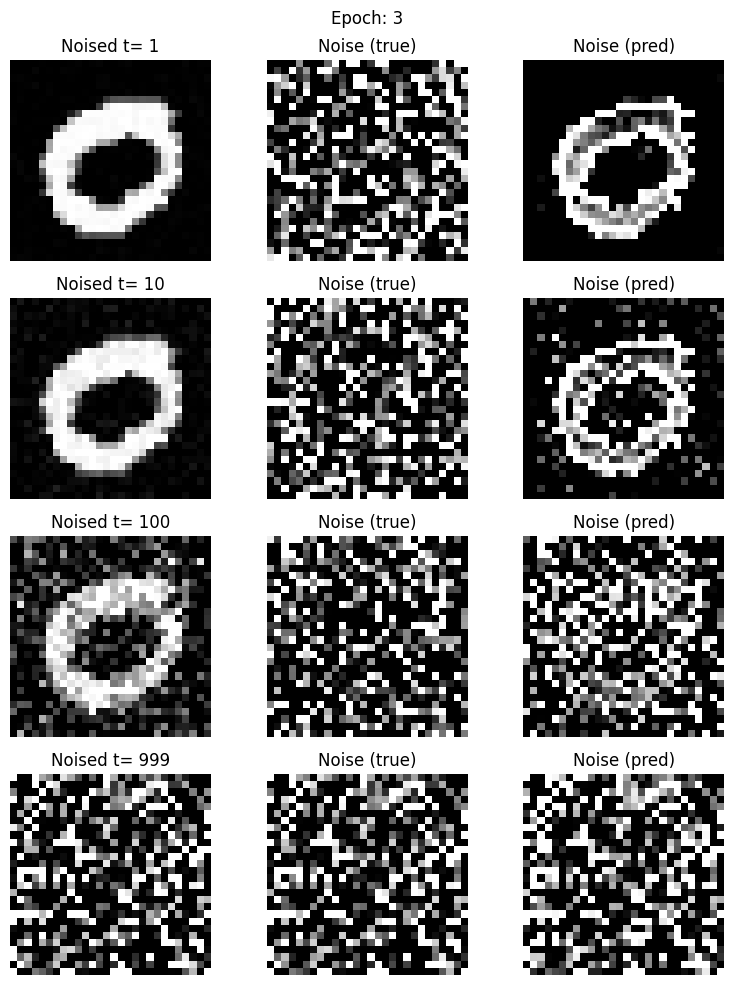

100%|██████████| 1000/1000 [00:10<00:00, 97.95it/s]


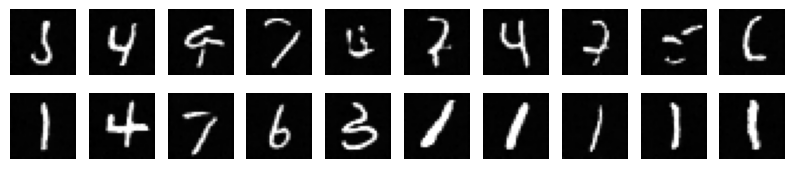

Epoch 3 | Loss: 0.01716327503808081
========Epoch: 4========


100%|██████████| 469/469 [00:55<00:00,  8.48it/s]


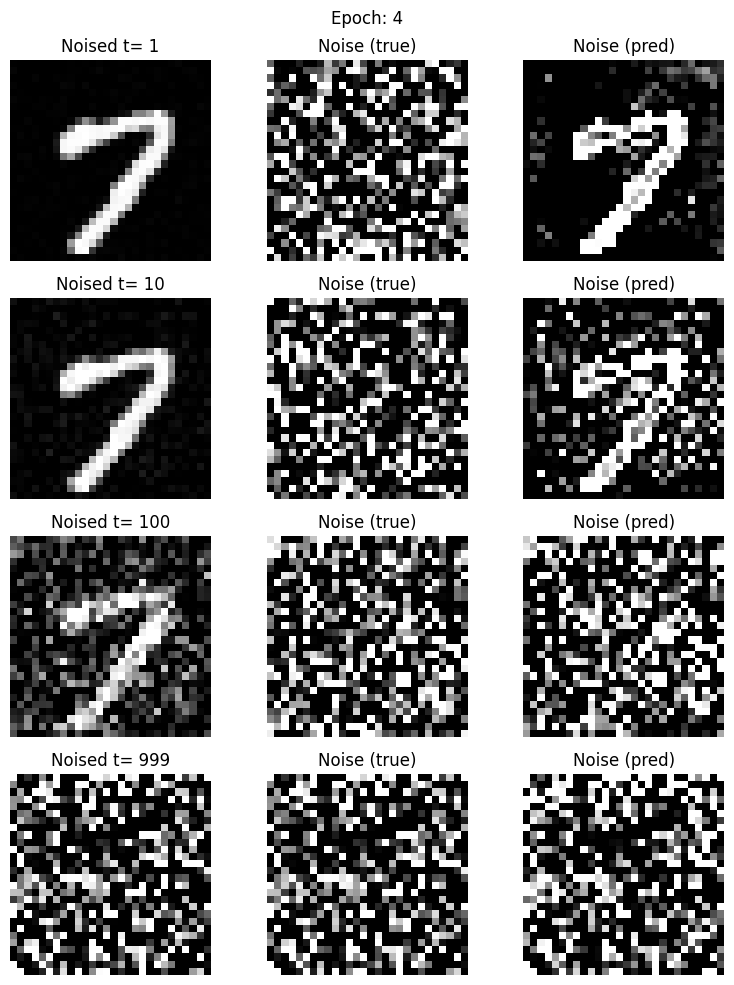

100%|██████████| 1000/1000 [00:10<00:00, 94.32it/s]


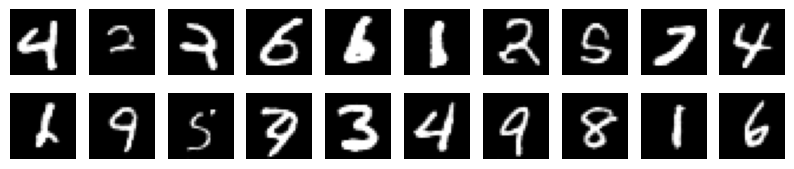

Epoch 4 | Loss: 0.016874703479362832
========Epoch: 5========


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


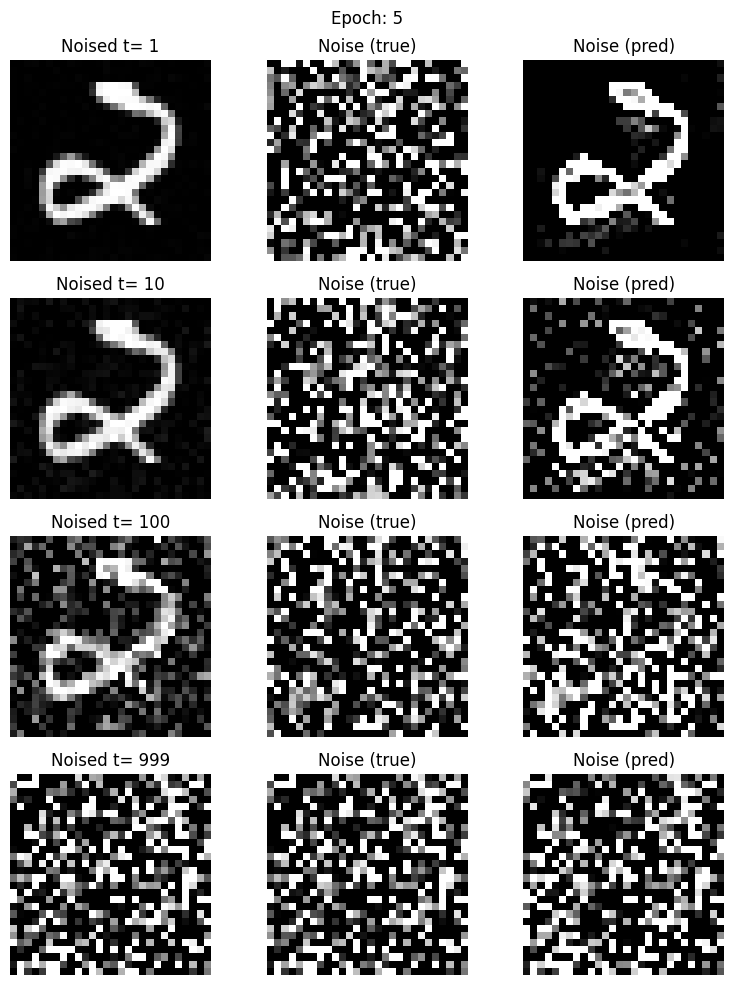

100%|██████████| 1000/1000 [00:10<00:00, 98.38it/s]


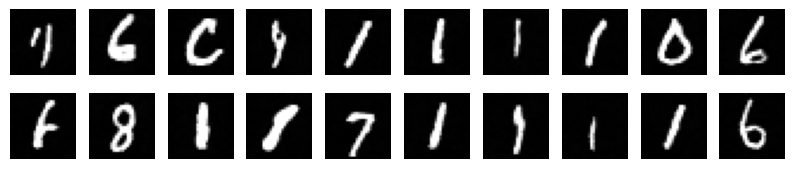

Epoch 5 | Loss: 0.01663518062770875
========Epoch: 6========


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


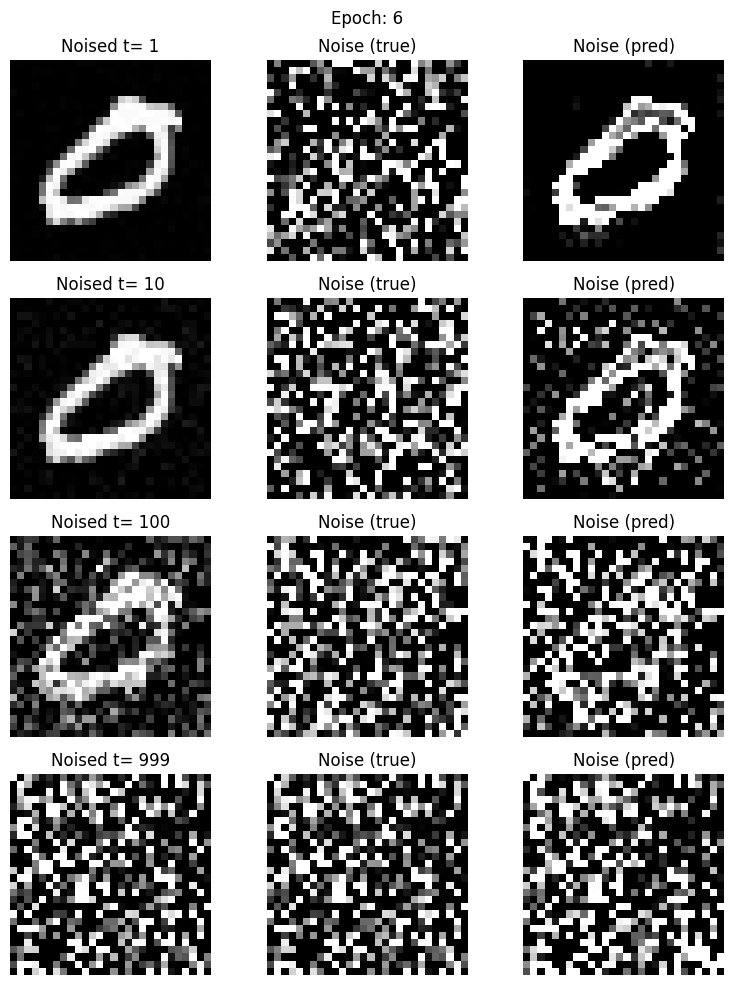

100%|██████████| 1000/1000 [00:10<00:00, 97.92it/s]


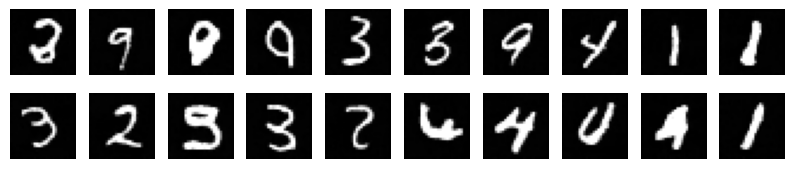

Epoch 6 | Loss: 0.016703861146005614
========Epoch: 7========


 10%|▉         | 45/469 [00:05<00:52,  8.05it/s]

In [ ]:


losses = []
for epoch in range(epochs):
    print(f"========Epoch: {epoch}========")
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    # images = diffuser.sample(model)
    # show_images(images)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)

        # ノイズ時刻tはランダムにsamplingして、ノイズの乗った画像x_noisyを作成する
        # t shape: 1, batchsize
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)
        x_noisy, noise = diffuser.add_noise(x, t)

        # modelはノイズを予測する
        # 実際のノイズと予測されたノイズのMean Square Error Lossを取る
        # TODO x0->xtのノイズを予測するの？1ステップではなく？
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    # 勉強用に可視化
    if epoch % 1 == 0:
        # We pick a single batch of images x from above to visualize
        # If you want a fresh batch for visualization, sample it again from the dataloader.
        ts = [1, 10, 100, 999]
        fig, axs = plt.subplots(len(ts), 3, figsize=(8, 10))
        fig.suptitle(f'Epoch: {epoch}')

        # We'll show results on the first image in the batch
        # If you want to use multiple images, just expand accordingly
        x_vis = x[:1]  # shape [1, C, H, W], for instance

        for i, t_ in enumerate(ts):
            # Construct a tensor of shape (batch_size,) = (1,) in this example
            t_tensor = torch.full((x_vis.shape[0],), t_, device=device, dtype=torch.long)

            with torch.no_grad():
                x_noisy_vis, noise_vis = diffuser.add_noise(x_vis, t_tensor)
                noise_pred_vis = model(x_noisy_vis, t_tensor)

            # Convert to NumPy for plotting
            noised_img = diffuser.reverse_to_img(x_noisy_vis[0])
            true_noise_img = diffuser.reverse_to_img(noise_vis[0])
            pred_noise_img = diffuser.reverse_to_img(noise_pred_vis[0])

            ax = axs[i]
            ax[0].imshow(noised_img,cmap="gray")
            ax[0].set_title(f'Noised t= {t_}')
            ax[0].axis('off')

            ax[1].imshow(true_noise_img,cmap="gray")
            ax[1].set_title('Noise (true)')
            ax[1].axis('off')

            ax[2].imshow(pred_noise_img,cmap="gray")
            ax[2].set_title('Noise (pred)')
            ax[2].axis('off')

        plt.tight_layout()
        plt.show()


        images = diffuser.sample(model)
        show_images(images)

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images = diffuser.sample(model)
show_images(images)